<img src="https://www.productboard.com/wp-content/uploads/2019/11/screen-shot-2019-11-07-at-4-18-51-pm.png" />

# Customer Segmentation -- Esimate individualized responses to incentives

Nowadays, business decision makers rely on estimating the causal effect of intervention to answer what-if questions about shifts in strategy, such as promoting specific product with discount, adding new features to the website or increasing investment from a sales team. However, other than learning whether to take action for a specific intervention, people are more interested in understanding the different responses from different users to the two alternatives. Identifying the characteristics of users having the strongest response for the intervention could help make rules to segment the future users into different groups. It will optimize the policy to use the least resources and get the most profit.

In this case study, we will use personalized pricing example to explain how our packages could fit into this problem and provide robust and reliable causal solutions.

### Summary of Contents:
1. [Background](#background)
2. [Data](#data)
3. [Create Causal Model](#create)
4. [Identify Causal Effect](#identify)
5. [Estimate CATE using EconML](#estimate)
6. [Robustness test](#robust)
7. [Interpret CATE](#interpret)
8. [Conclusion](#conclusion)



# Background <a id="background"></a>

<img src="https://cdn.pixabay.com/photo/2018/08/16/11/59/radio-3610287_960_720.png" width="400" />

Global online media market is growing fast over the years. The media company is always interested to attract more users into the market and encourage them to buy more songs or become members. One of the experiment they are running is to give personalized discount for the current and potential users in order to boost the likelihood of their purchase. They'd like to learn heterogeneous treatment effect of personlized discount on overall demand. EconML’s DML estimator uses discount variation in existing data, along with a rich set of user features, to estimate heterogeneous price sensitivities that vary with multiple customer features. The tree interpreter provides a presentation-ready summary of the key features that explain the biggest differences in responsiveness to a discount, which could help the company to better target the users in the future. 

# Data <a id="data"></a>

We run an experiment giving personalized discount to our users based on their previous purchase history in our online store in a month and learn how many songs they are gonna buy during this special event season. We also collect users demographic and behaviour features as confounders. For confidential reason, we will use the simulated data as an example here. The simulated data will have the similar data property and format with the real world dataset.

The dataset has ~10,000 observations and includes 10 continuous and categorical variables that represent user's characteristics and listening behaviour history such as age, log income, previous purchase, average hours online per week, etc. We define the following variables:

* Y: Songs sales over the discount period
* T: Personalized discount
* X: Log-income, has membership, average days visited in a week before discount period  
* W: Demographic and user behaviour features
* $\theta(X)$: Heterogeneous price elasticity of demand

The goal is to learn heterogeneous treatment effect of personalized discount on sales. Thus, we model the world as follows:
$$
\begin{align}
log(Y) & =  \theta(X) \cdot log(T) + f(W) + \epsilon \\
log(T) &= g(W) + \eta
\end{align}
$$
where $\epsilon, \eta$ are uncorrelated error terms.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import dowhy
from dowhy import CausalModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
import seaborn as sns

## Ignore warnings
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(123)
n = 10000
w_dict = {
    "age": lambda: np.random.randint(18, 61, size=n),  # age of the user
    "is_US": lambda: np.random.binomial(
        1, 0.8, size=n
    ),  # location of the user (US or not)
    "avg_hours": lambda: np.clip(
        np.random.normal(5, 2, size=n), 0, None
    ),  # the average hours users are online per week
    "account_age": lambda: np.random.randint(
        0, 6, size=n
    ),  # the account age of the user
    "songs_quant": lambda: np.clip(
        np.random.normal(10, 3, size=n), 0, None
    ),  # average number of songs purchased in the past per week
    "songs_spent": lambda: np.clip(
        np.random.normal(15, 5, size=n), 0, None
    ),  # average songs spent in the past per week
    "friend_count": lambda: np.random.binomial(
        20, 0.5, size=n
    ),  # number of friends for that account
}
x_dict = {
    "income": lambda: np.random.lognormal(0, 0.5, size=n),  # income of the user
    "has_membership": lambda: np.random.binomial(
        1, 0.5, size=n
    ),  # whether the user has membership}
    "days_visited": lambda: np.random.randint(
        0, 8, size=n
    ),  # number of days visited the website in the last week before discount period.
}

<IPython.core.display.Javascript object>

In [4]:
W_data = {colname: func() for colname, func in w_dict.items()}
X_data = {colname: func() for colname, func in x_dict.items()}
W_data = pd.DataFrame({**W_data})
X_data = pd.DataFrame({**X_data})

<IPython.core.display.Javascript object>

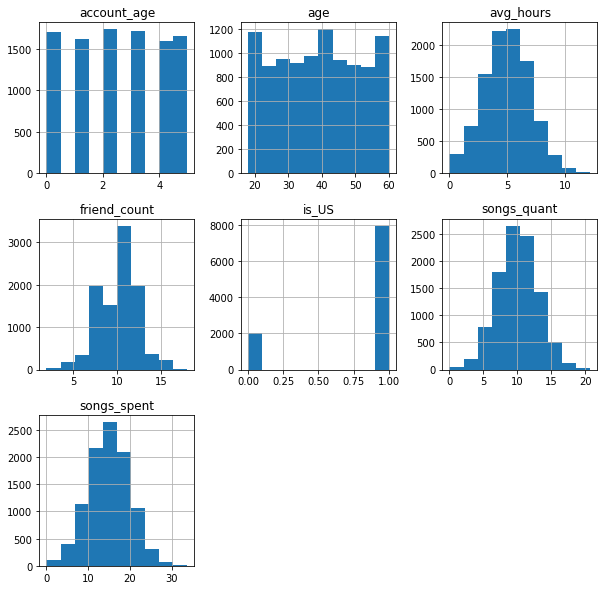

<IPython.core.display.Javascript object>

In [5]:
hist = W_data.hist(bins=10, figsize=((10, 10)))

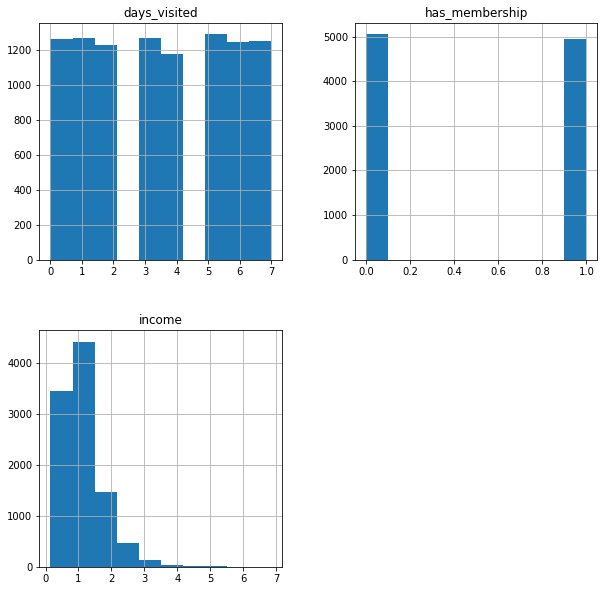

<IPython.core.display.Javascript object>

In [6]:
hist = X_data.hist(bins=10, figsize=((10, 10)))

In [7]:
epsilon_sample = lambda n: np.random.uniform(0, 0.1, size=n)
eta_sample = lambda n: np.random.uniform(0, 0.1, size=n)
# Heterogeneous treatment effects, income, has_membership and days_visited creates heterogeneity
TE = (
    -1
    + 0.2 * X_data["income"]
    - 1 * X_data["has_membership"]
    - 0.15 * X_data["days_visited"]
)
# Define treatment
log_T = -0.004 * W_data["songs_spent"] + eta_sample(n)
T = np.exp(log_T)
# Define the outcome with treatment effect heterogeneity
log_Y = (
    3
    + TE * log_T
    + 0.1 * W_data["songs_spent"]
    - 0.04 * W_data["age"]
    - epsilon_sample(n)
)
Y = np.exp(log_Y)

<IPython.core.display.Javascript object>

(array([ 868., 1245., 1218., 1653., 1541., 1252., 1262.,  853.,  100.,
           8.]),
 array([-2.99484484, -2.69759015, -2.40033546, -2.10308077, -1.80582608,
        -1.50857139, -1.2113167 , -0.91406201, -0.61680733, -0.31955264,
        -0.02229795]),
 <a list of 10 Patch objects>)

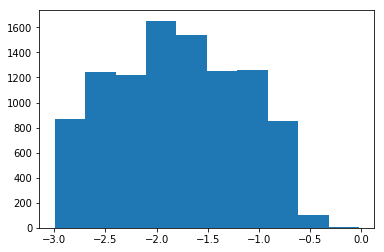

<IPython.core.display.Javascript object>

In [8]:
# distribution of treatment effect, should be always >0, positive to discount
plt.hist(TE)

(array([  10.,  120.,  661., 1509., 2118., 2130., 2027., 1070.,  321.,
          34.]),
 array([-0.12773053, -0.10537024, -0.08300995, -0.06064965, -0.03828936,
        -0.01592906,  0.00643123,  0.02879153,  0.05115182,  0.07351211,
         0.09587241]),
 <a list of 10 Patch objects>)

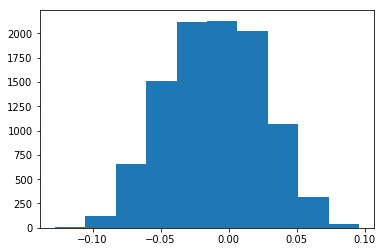

<IPython.core.display.Javascript object>

In [9]:
# distribution of log_T
plt.hist(log_T)

(array([  17.,  166.,  901., 1773., 2146., 2108., 1785.,  838.,  236.,
          30.]),
 array([0.8800905 , 0.90214331, 0.92419613, 0.94624894, 0.96830175,
        0.99035456, 1.01240738, 1.03446019, 1.056513  , 1.07856581,
        1.10061862]),
 <a list of 10 Patch objects>)

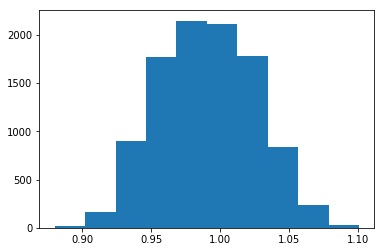

<IPython.core.display.Javascript object>

In [10]:
# distribution of treatment discount, should be in range (0.9,1.1)
plt.hist(T)

(array([  26.,  175.,  748., 1694., 2431., 2423., 1649.,  671.,  160.,
          23.]),
 array([0.44521089, 0.94158874, 1.43796659, 1.93434445, 2.4307223 ,
        2.92710016, 3.42347801, 3.91985587, 4.41623372, 4.91261158,
        5.40898943]),
 <a list of 10 Patch objects>)

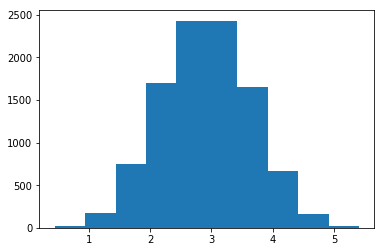

<IPython.core.display.Javascript object>

In [11]:
# distribution of log_Y
plt.hist(log_Y)

(array([6.241e+03, 2.683e+03, 7.170e+02, 2.280e+02, 8.200e+01, 2.600e+01,
        1.300e+01, 7.000e+00, 2.000e+00, 1.000e+00]),
 array([  1.56081932,  23.74530803,  45.92979675,  68.11428547,
         90.29877419, 112.48326291, 134.66775162, 156.85224034,
        179.03672906, 201.22121778, 223.4057065 ]),
 <a list of 10 Patch objects>)

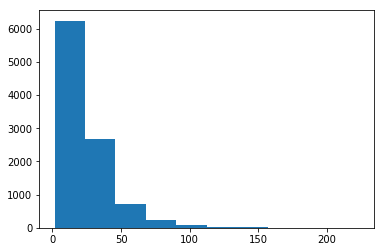

<IPython.core.display.Javascript object>

In [12]:
# distribution of sales Y, should be always larger than 0 and in reasonable range
plt.hist(Y)

In [13]:
# Create dataframe
data = pd.concat([W_data, X_data], axis=1)
data["log_discount"] = log_T
data["log_sales"] = log_Y

<IPython.core.display.Javascript object>

In [14]:
data.head()

,age,is_US,avg_hours,account_age,songs_quant,songs_spent,friend_count,income,has_membership,days_visited,log_discount,log_sales
0,20,0,1.632908,4,13.589269,9.180203,6,1.091881,0,0,-0.010716,3.100263
1,46,1,4.082370,3,9.911708,20.928378,7,0.844025,0,5,-0.002329,3.237892
2,52,1,5.608632,5,12.518181,13.983480,12,0.542159,1,1,-0.031973,2.349772
3,56,1,4.257174,2,15.538423,25.133606,12,0.515544,1,2,-0.071587,3.385402
4,35,0,6.272593,0,9.677467,6.396755,16,2.868644,0,2,0.053018,2.185996


<IPython.core.display.Javascript object>

In [15]:
# get testing data
n = 100
X_test = {colname: func() for colname, func in x_dict.items()}
data_test = pd.DataFrame(X_test)
data_test.head()

,income,has_membership,days_visited
0,0.652932,1,7
1,1.226470,1,3
2,1.457277,0,1
3,1.688476,1,2
4,0.627000,1,2


<IPython.core.display.Javascript object>

# Create causal model <a id="create"></a>


In [16]:
W_names = W_data.columns.tolist()
X_names = X_data.columns.tolist()

<IPython.core.display.Javascript object>

In [17]:
# Create a causal model from the data
model = CausalModel(
    data=data,
    treatment="log_discount",
    outcome="log_sales",
    common_causes=W_names + X_names,
    effect_modifiers=X_names,
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['log_discount'] on outcome ['log_sales']


<IPython.core.display.Javascript object>

INFO:dowhy.causal_graph:Using Matplotlib for plotting


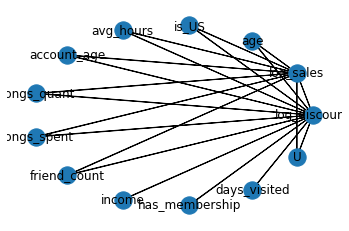

<IPython.core.display.Javascript object>

In [18]:
model.view_model()

# Identify causal effect <a id="identify"></a>


In [19]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['songs_spent', 'U', 'avg_hours', 'is_US', 'age', 'friend_count', 'has_membership', 'account_age', 'income', 'songs_quant', 'days_visited']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(Expectation(log_sales|songs_spent,avg_hours,is_US,age,friend_c
d[log_discount]                                                               

                                                                 
ount,has_membership,account_age,income,songs_quant,days_visited))
                                                                 
Estimand assumption 1, Unconfoundedness: If U→{log_discount} and U→log_sales then P(log_sales|log_discount,songs_spent,avg_hours,is_US,age,friend_count,has_membership,account_age,income,songs_quant,days_visited,U) = P(log_sales|log_discount,songs_spent,avg_hours,is_US,age,friend_count,has_membership,account_age,income,songs_quant,days_visited)
### Estimand : 2
Estimand name: iv
No such variable found!



<IPython.core.display.Javascript object>

# Estimate CATE using EconML <a id="estimate"></a>

## Train estimator

In [37]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_sales~log_discount+songs_spent+avg_hours+is_US+age+friend_count+has_membership+account_age+income+songs_quant+days_visited


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(Expectation(log_sales|songs_spent,avg_hours,is_US,age,friend_c
d[log_discount]                                                               

                                                                 
ount,has_membership,account_age,income,songs_quant,days_visited))
                                                                 
Estimand assumption 1, Unconfoundedness: If U→{log_discount} and U→log_sales then P(log_sales|log_discount,songs_spent,avg_hours,is_US,age,friend_count,has_membership,account_age,income,songs_quant,days_visited,U) = P(log_sales|log_discount,songs_spent,avg_hours,is_US,age,friend_count,has_membership,account_age,income,songs_quant,days_visited)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estiman

<IPython.core.display.Javascript object>

In [44]:
est = dml_estimate._estimator_object
truth_te = (
    -1
    + 0.2 * data_test["income"]
    - 1 * data_test["has_membership"]
    - 0.15 * data_test["days_visited"]
)
print("True ATE is", np.mean(truth_te))

True ATE is -1.7849276781872854


<IPython.core.display.Javascript object>

## Prediction Visualization

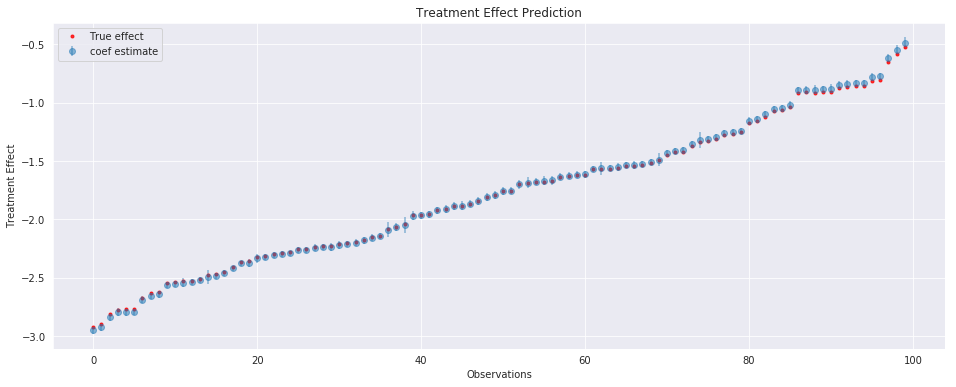

<IPython.core.display.Javascript object>

In [39]:
pred_te = dml_estimate.cate_estimates.flatten()
lb = dml_estimate.effect_intervals[0].flatten()
ub = dml_estimate.effect_intervals[1].flatten()
yerr = np.zeros((2, pred_te.shape[0]))
yerr[0, :] = pred_te - lb
yerr[1, :] = ub - pred_te
indices = np.argsort(pred_te)


with sns.axes_style("darkgrid"):
    plt.figure(figsize=(16, 6))
    plt.errorbar(
        range(100),
        pred_te[indices],
        yerr[:, indices],
        fmt="o",
        label="coef estimate",
        alpha=0.5,
    )
    plt.plot(range(100), truth_te[indices], "r.", label="True effect", alpha=0.8)
    plt.xlabel("Observations")
    plt.ylabel("Treatment Effect")
    plt.title("Treatment Effect Prediction")
    plt.legend()

## Heterogeneity visualization

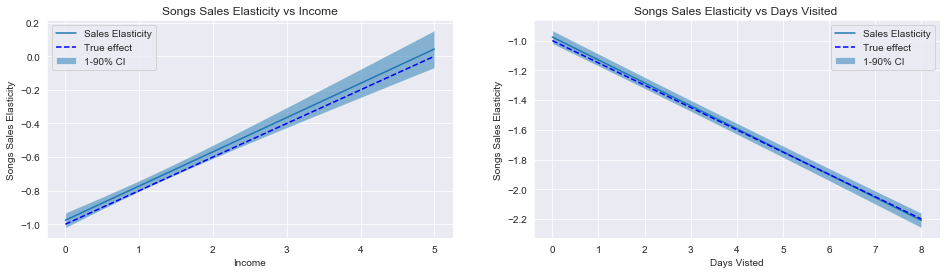

<IPython.core.display.Javascript object>

In [52]:
X_test1 = np.zeros_like(data_test.values)
X_test1[:, 0] = np.linspace(0, 5, 100)
te_pred1 = est.effect(X_test1).flatten()
te_pred_interval1 = est.effect_interval(X_test1)
truth_te1 = -1 + np.dot(X_test1, np.array([0.2, -1, -0.15]))

X_test2 = np.zeros_like(data_test.values)
X_test2[:, 2] = np.linspace(0, 8, 100)
te_pred2 = est.effect(X_test2).flatten()
te_pred_interval2 = est.effect_interval(X_test2)
truth_te2 = -1 + np.dot(X_test2, np.array([0.2, -1, -0.15]))

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(X_test1[:, 0], te_pred1, label="Sales Elasticity")
    plt.plot(X_test1[:, 0], truth_te1, "b--", label="True effect")
    plt.fill_between(
        X_test1[:, 0],
        te_pred_interval1[0].flatten(),
        te_pred_interval1[1].flatten(),
        alpha=0.5,
        label="1-90% CI",
    )
    plt.xlabel("Income")
    plt.ylabel("Songs Sales Elasticity")
    plt.title("Songs Sales Elasticity vs Income")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(X_test2[:, 2], te_pred2, label="Sales Elasticity")
    plt.plot(X_test2[:, 2], truth_te2, "b--", label="True effect")
    plt.fill_between(
        X_test2[:, 2],
        te_pred_interval2[0].flatten(),
        te_pred_interval2[1].flatten(),
        alpha=0.5,
        label="1-90% CI",
    )
    plt.xlabel("Days Visted")
    plt.ylabel("Songs Sales Elasticity")
    plt.title("Songs Sales Elasticity vs Days Visited ")
    plt.legend()

    plt.show()

## Parameter summary

In [53]:
est.summary(feat_name=X_names)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
income,0.204,0.017,12.125,0.0,0.176,0.231
has_membership,-1.023,0.02,-51.125,0.0,-1.056,-0.99
days_visited,-0.154,0.004,-35.551,0.0,-0.161,-0.147
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
intercept,-0.976,0.028,-35.051,0.0,-1.022,-0.93


<IPython.core.display.Javascript object>

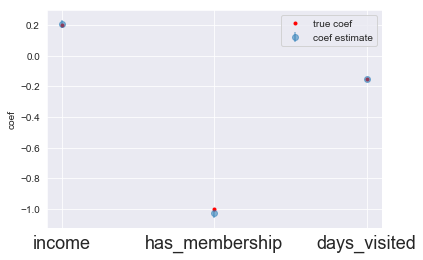

<IPython.core.display.Javascript object>

In [54]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(X_names)
point = est.coef_.flatten()
lower, upper = np.array(est.coef__interval())
lower = lower.flatten()
upper = upper.flatten()
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1, 1)
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt="o", label="coef estimate", alpha=0.5)
    plt.plot([0.2, -1, -0.15], "r.", label="true coef", alpha=1)
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, fontsize=18)
    ax.set_ylabel("coef")
    plt.legend()
    plt.show()

# Robustness test <a id="robust"></a>

## Random common cause

In [33]:
res_random = model.refute_estimate(
    identified_estimand, dml_estimate, method_name="random_common_cause"
)
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_sales~log_discount+friend_count+age+songs_quant+songs_spent+avg_hours+account_age+is_US+w_random


Refute: Add a Random Common Cause
Estimated effect:(-1.7826935891974538,)
New effect:(-1.784774615804844,)



<IPython.core.display.Javascript object>

## Adding an unobserved common cause variable

In [34]:
from econml.cate_interpreter import SingleTreeCateInterpreter

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_sales~log_discount+friend_count+age+songs_quant+songs_spent+avg_hours+account_age+is_US


Refute: Add an Unobserved Common Cause
Estimated effect:(-1.7826935891974538,)
New effect:(-1.7809658734163434,)



<IPython.core.display.Javascript object>

## Replacing treatment with a random (placebo) variable

In [35]:
intrp = SingleTreeCateInterpreter(
    include_model_uncertainty=True, max_depth=2, min_samples_leaf=10
)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, data_test)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_sales~placebo+friend_count+age+songs_quant+songs_spent+avg_hours+account_age+is_US


Refute: Use a Placebo Treatment
Estimated effect:(-1.7826935891974538,)
New effect:(-0.015934987204663072,)



<IPython.core.display.Javascript object>

## Removing a random subset of the data

In [36]:
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_names, fontsize=12)
plt.show()

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: log_sales~log_discount+friend_count+age+songs_quant+songs_spent+avg_hours+account_age+is_US


Refute: Use a subset of data
Estimated effect:(-1.7826935891974538,)
New effect:(-1.7885526088714323,)



<IPython.core.display.Javascript object>

# Interpret CATE <a id="interpret"></a>
## Tree Interpretation of the CATE Model

In [34]:
from econml.cate_interpreter import SingleTreeCateInterpreter

<IPython.core.display.Javascript object>

In [35]:
intrp = SingleTreeCateInterpreter(
    include_model_uncertainty=True, max_depth=2, min_samples_leaf=10
)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, data_test)

<IPython.core.display.Javascript object>

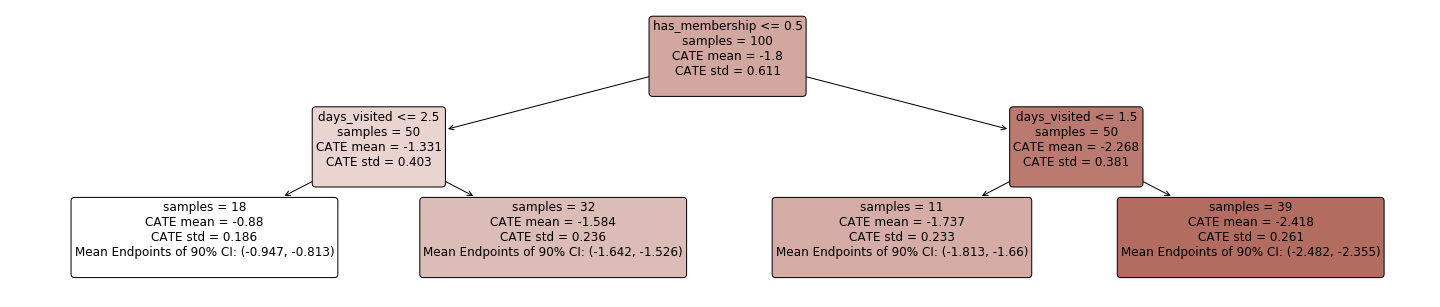

<IPython.core.display.Javascript object>

In [36]:
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_names, fontsize=12)
plt.show()

## Tree Based Treatment Policy Based on CATE Model

In [37]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

<IPython.core.display.Javascript object>

In [38]:
intrp = SingleTreePolicyInterpreter(
    risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001
)
intrp.interpret(est, data_test, sample_treatment_costs=-1)

<IPython.core.display.Javascript object>

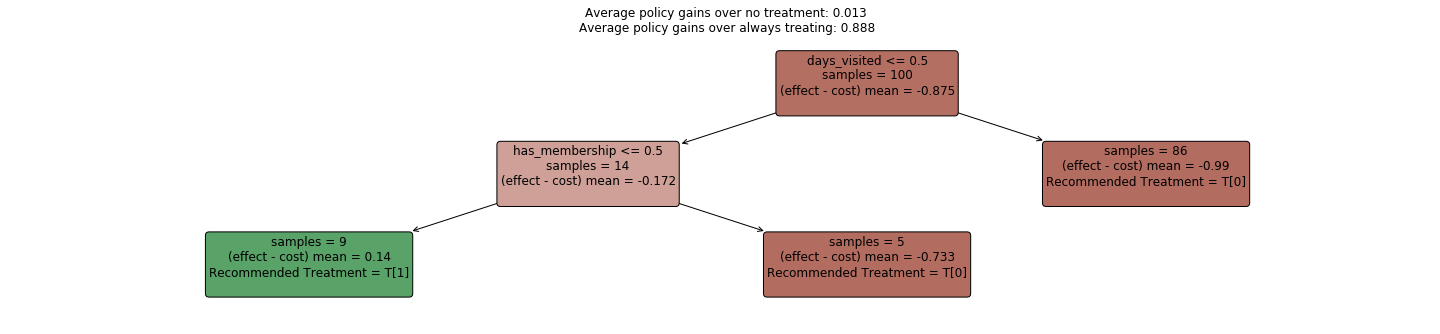

<IPython.core.display.Javascript object>

In [39]:
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_names, fontsize=12)
plt.show()

## Rank top 20% users

Text(0, 0.5, 'Normalized days visited ')

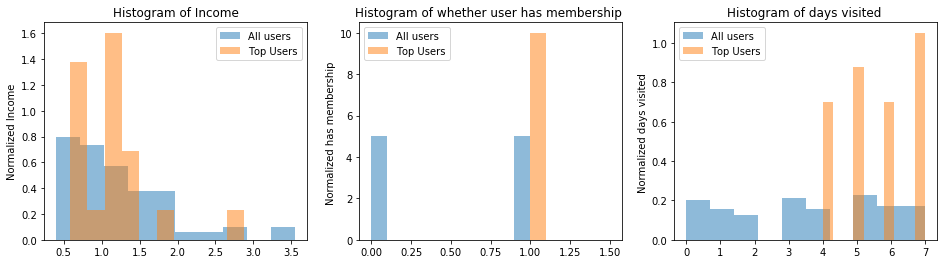

<IPython.core.display.Javascript object>

In [85]:
data_test["pred_te"] = pred_te
data_test["te_rank"] = data_test["pred_te"].rank()
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.hist(data_test["income"], normed=True, alpha=0.5, label="All users")
plt.hist(
    data_test[data_test["te_rank"] < 20]["income"],
    normed=True,
    alpha=0.5,
    label="Top Users",
)
plt.legend()
plt.title("Histogram of Income")
plt.ylabel("Normalized Income")

plt.subplot(1, 3, 2)
plt.hist(data_test["has_membership"], normed=True, alpha=0.5, label="All users")
plt.hist(
    data_test[data_test["te_rank"] < 20]["has_membership"],
    normed=True,
    alpha=0.5,
    label="Top Users",
)
plt.legend()
plt.title("Histogram of whether user has membership ")
plt.ylabel("Normalized has membership ")

plt.subplot(1, 3, 3)
plt.hist(data_test["days_visited"], normed=True, alpha=0.5, label="All users")
plt.hist(
    data_test[data_test["te_rank"] < 20]["days_visited"],
    normed=True,
    alpha=0.5,
    label="Top Users",
)
plt.legend()
plt.title("Histogram of days visited ")
plt.ylabel("Normalized days visited ")

# Conclusion <a id="conclusion"></a>